# Generative linear models para ver tendencias de COVID-19 en Chile

## Origen de datos
Ahora es un poco más tramite la importación, pero se alimenta de una [fuente sustentable de datos](https://chilecracia.org/#datos)

In [53]:
import pandas as pd

raw_df = pd.read_csv('data-covid19.csv', parse_dates=[0])

colmap = {
    'casos_acum': 'total_cases',
    'confirmados': 'new_cases',
}
to_drop = ['total_cada_100mil', 'fallecidos_nuevos', 'fallecidos_acum', 'notificados_acum']
df = raw_df.groupby('fecha').sum().rename(columns=colmap).drop(columns=to_drop)
df.tail()

,total_cases,new_cases
fecha,,
2020/04/11,6927,426
2020/04/12,7213,286
2020/04/13,7525,312
2020/04/14,7917,392
2020/04/15,8273,356


In [54]:
df.reset_index(inplace=True)
df['ds'] = pd.to_datetime(df.fecha)
df.drop(columns=['fecha'], inplace=True)
df.tail()

,total_cases,new_cases,ds
39,6927,426,2020-04-11
40,7213,286,2020-04-12
41,7525,312,2020-04-13
42,7917,392,2020-04-14
43,8273,356,2020-04-15


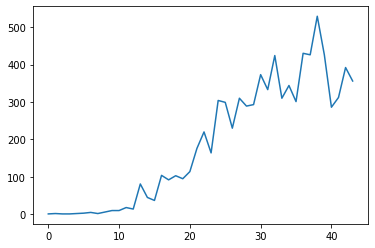

In [55]:
# Los miramos en el grafico
df.new_cases.plot()

In [56]:
import numpy as np

# Preparamos X, y
X = np.expand_dims(df.index.to_numpy(), 1)
y = df.new_cases

In [57]:
# FUERA DE USO
# Alternativa para hacer grid search de splines

#gam = LinearGAM(n_splines=25,spline_order=3)
#gam.gridsearch(X, y, n_splines=np.arange(50))

In [58]:
# FUERA DE USO
# Alternativa para hacer grid search de lambadas

#gam = LinearGAM(n_splines=4,spline_order=3).gridsearch(X, y, lam=np.logspace(-12, 12, 5000))

In [59]:
from pygam import LinearGAM, s, f

# Definimos nuetras GAM como una linear de s(0, n_splines=n_splines)
n_splines = 20
gam = LinearGAM(s(0, n_splines=n_splines))

In [60]:
# Hacemos fit
gam.fit(X, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

In [61]:
# Un sumario

gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.7776
Link Function:                     IdentityLink Log Likelihood:                                  -373.0174
Number of Samples:                           44 AIC:                                              765.5899
                                                AICc:                                             771.9337
                                                GCV:                                             2954.3671
                                                Scale:                                           1917.0067
                                                Pseudo R-Squared:                                   0.9405
Feature Function                  Lam

<ipython-input-61-4bebcc94ea8e>:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


### Ploteamos las predicciones para para el modelo y sus intervalos

In [62]:
df.ds.min()

Timestamp('2020-03-03 00:00:00')

In [63]:
#df.ds.max().date()
df.ds.max().to_pydatetime()

datetime.datetime(2020, 4, 15, 0, 0)

In [64]:
# Pongamos fechas bonitas
import datetime

def nday2datetime(nday):
    #base_date = datetime.datetime(2020, 3, 2)
    base_date = df.ds.min().to_pydatetime()
    return base_date + datetime.timedelta(days=nday)

def nday2datetime_list(nday_list):
    result = []
    for nday in nday_list:
        result.append(nday2datetime(nday))
        
    return result


df['ds'] = pd.Series(df.index).apply(nday2datetime)

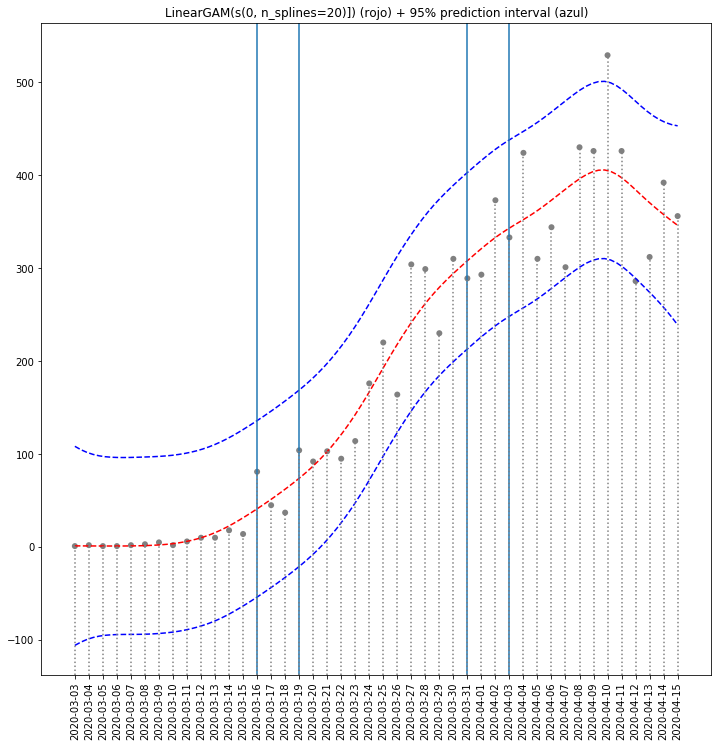

In [65]:
import matplotlib.pyplot as plt

def plot_gam(gam, title, X, y, save = False):
    fig, ax = plt.subplots(figsize=(12, 12))
    #plt.figure(figsize=(12, 12));

    XX = gam.generate_X_grid(0)

    plt.plot(nday2datetime_list(XX[:, 0]), gam.predict(XX), 'r--')
    plt.plot(nday2datetime_list(XX[:, 0]), gam.prediction_intervals(XX), color='b', ls='--')

    plt.scatter(X, y, facecolor='gray', edgecolors='none')
    plt.title(title)
    plt.xticks(X, rotation=90)
    
    # Marks
    plt.axvline(datetime.datetime(2020, 3, 16)) # Cierre clases
    plt.axvline(datetime.datetime(2020, 3, 19)) # Cierre comercio
    
    plt.axvline(datetime.datetime(2020, 3, 16) + datetime.timedelta(days=15)) # Cierre clases
    plt.axvline(datetime.datetime(2020, 3, 19) + datetime.timedelta(days=15)) # Cierre comercio
    
    # Create transformers for lines
    data2figure_trans = ax.transData
    figure2ax_trans = ax. transAxes.inverted()
    
    for point in zip(X, y.values):
        # Convert point from data to figure cordinate system
        f_point = data2figure_trans.transform([0, point[1]])
        # Convert point from figure to axis coordinate system
        a_point = figure2ax_trans.transform(f_point)
        
        plt.axvline(point[0], ymax=a_point[1], linestyle=':', color='gray')
    if save:
        plt.savefig(f'plots/{title}.png')
    plt.show()
    plt.close()
        
plot_gam(gam, f'LinearGAM(s(0, n_splines={n_splines})]) (rojo) + 95% prediction interval (azul)', df.ds, y)

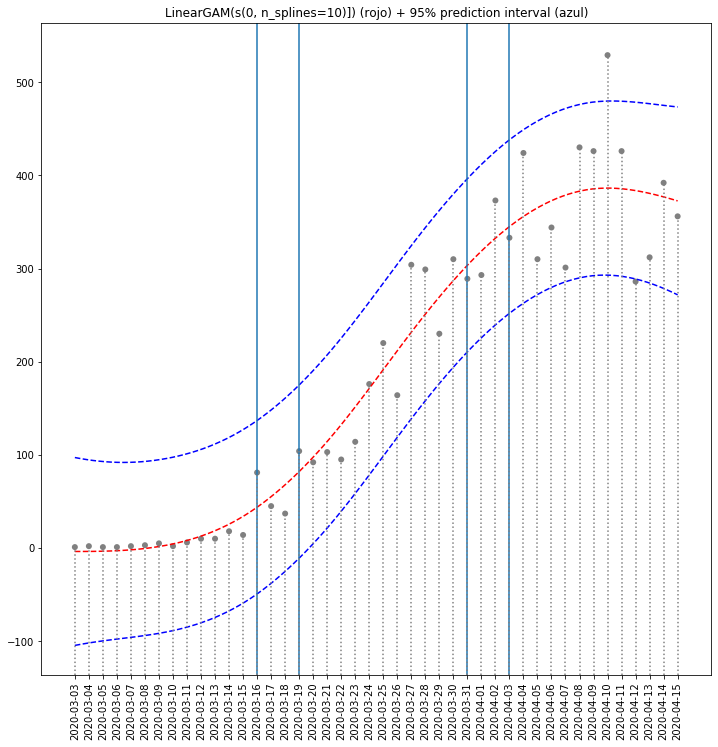

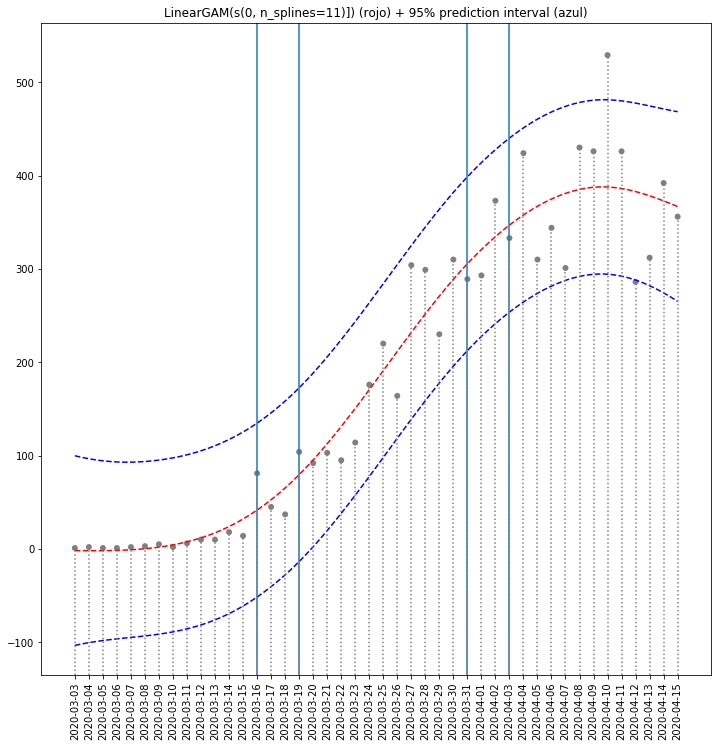

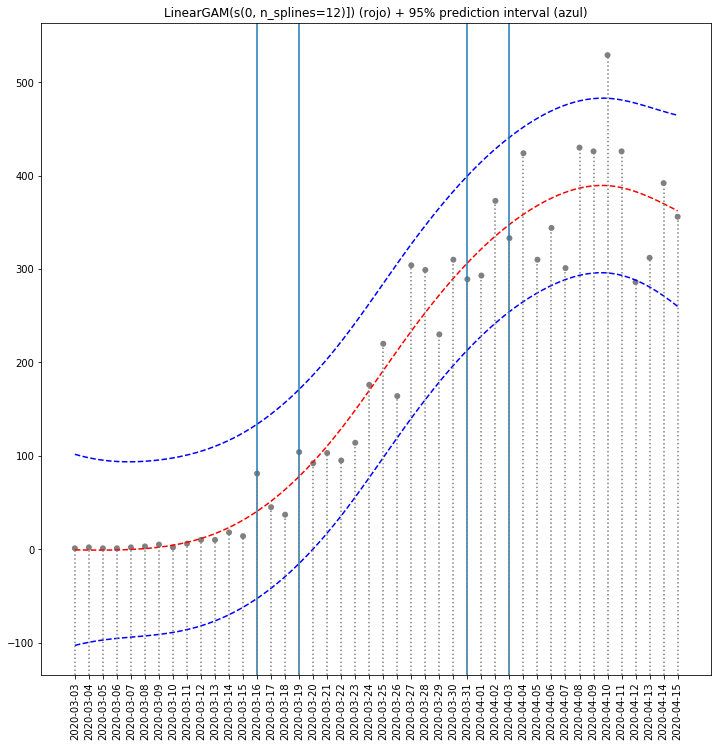

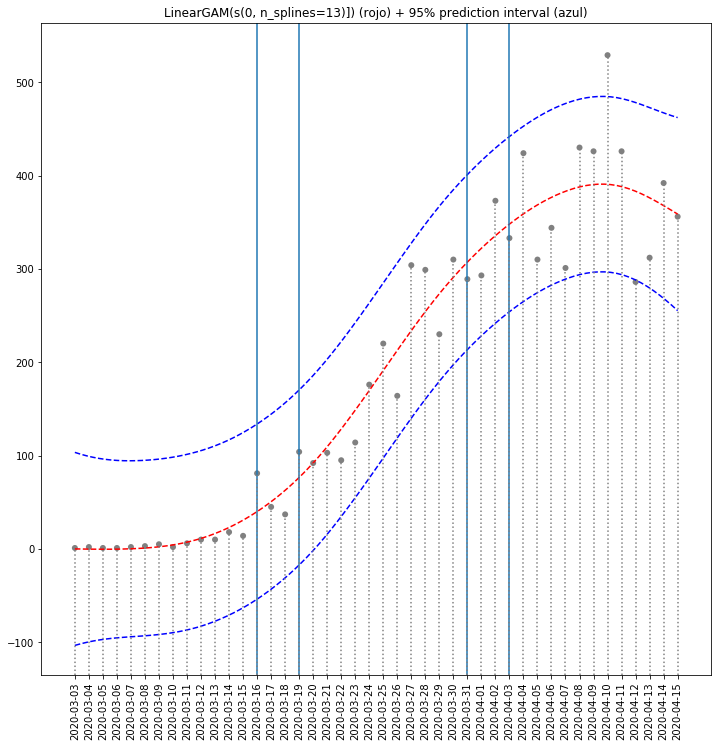

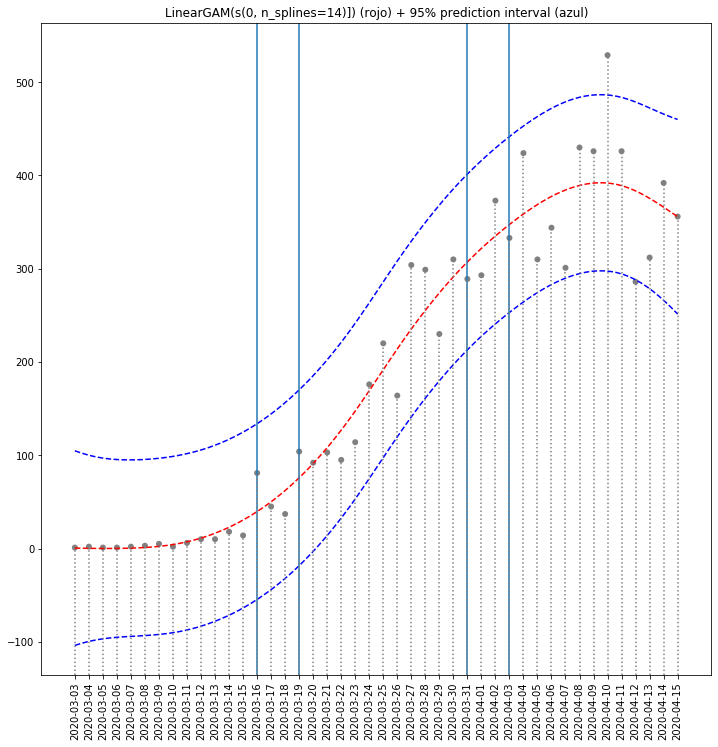

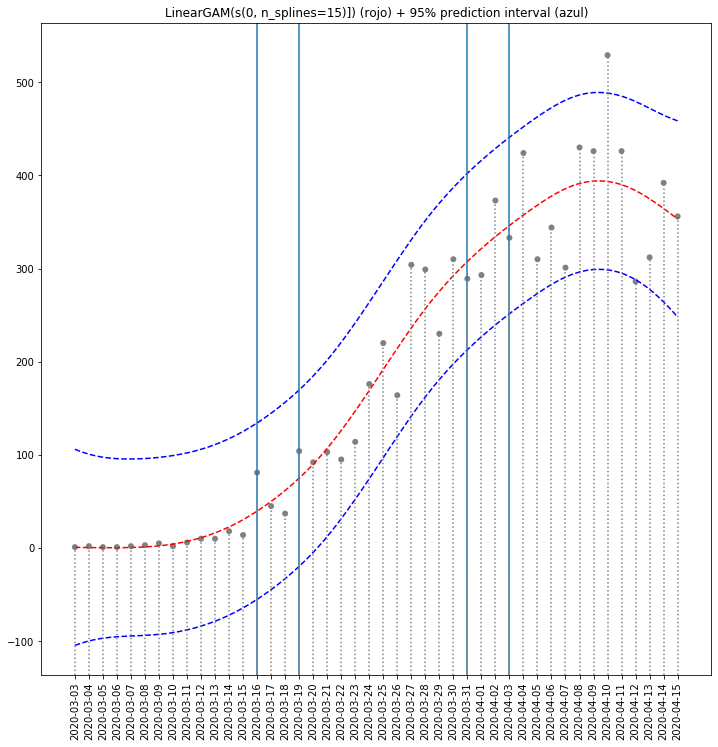

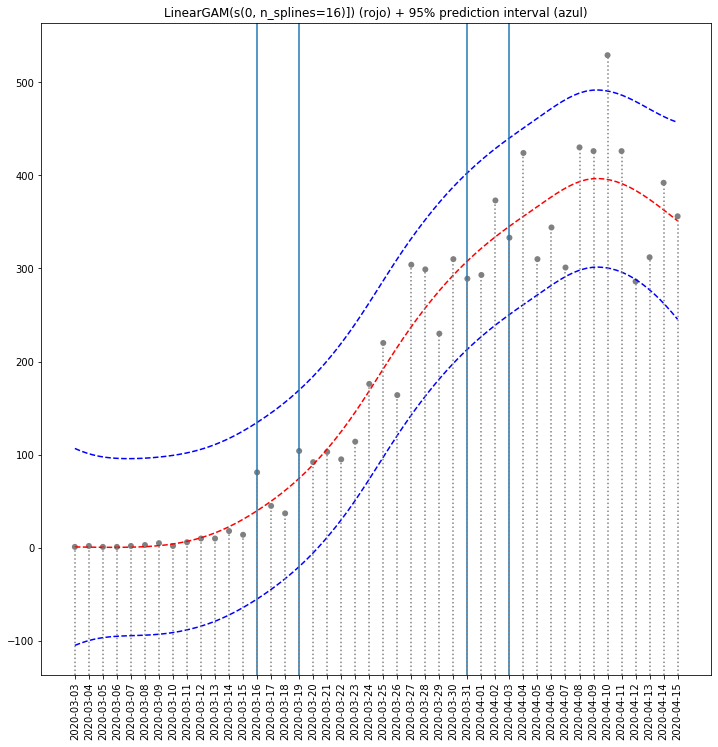

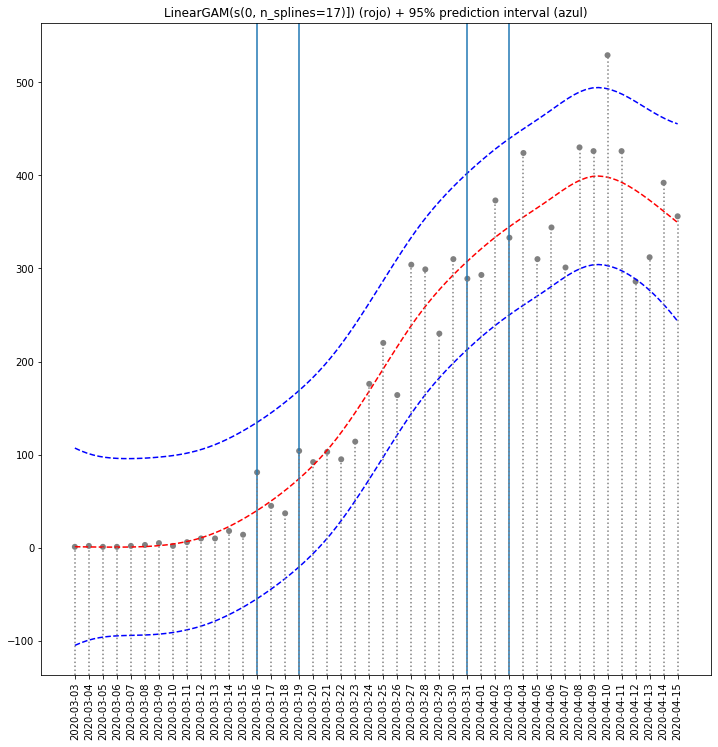

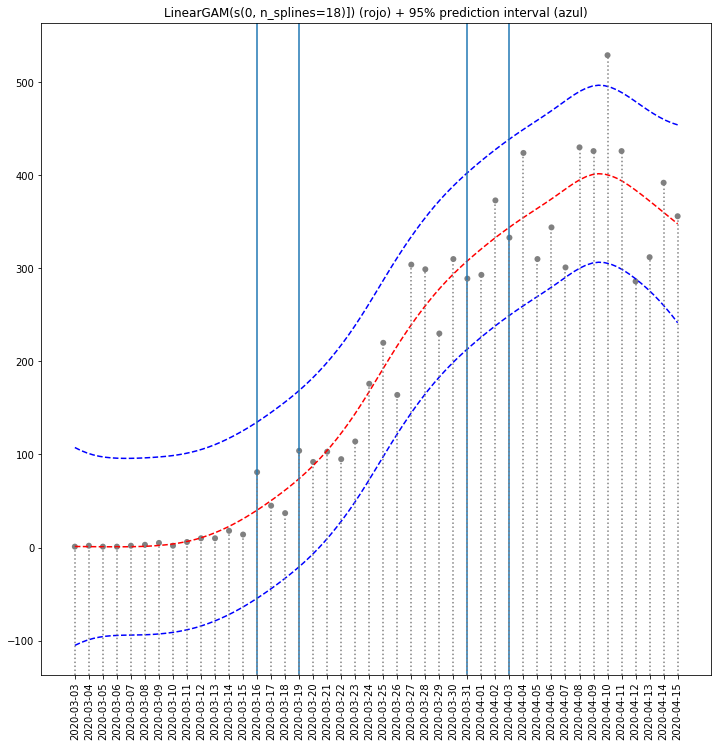

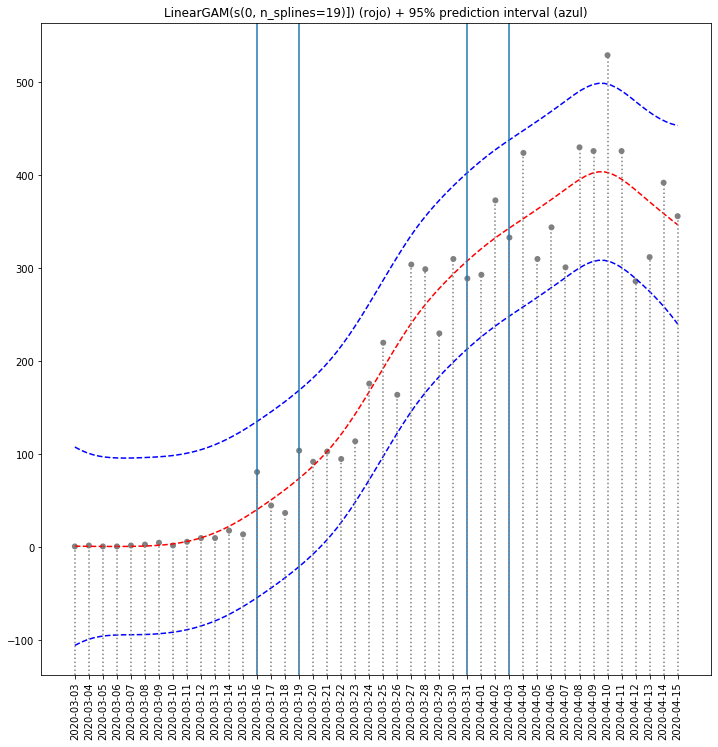

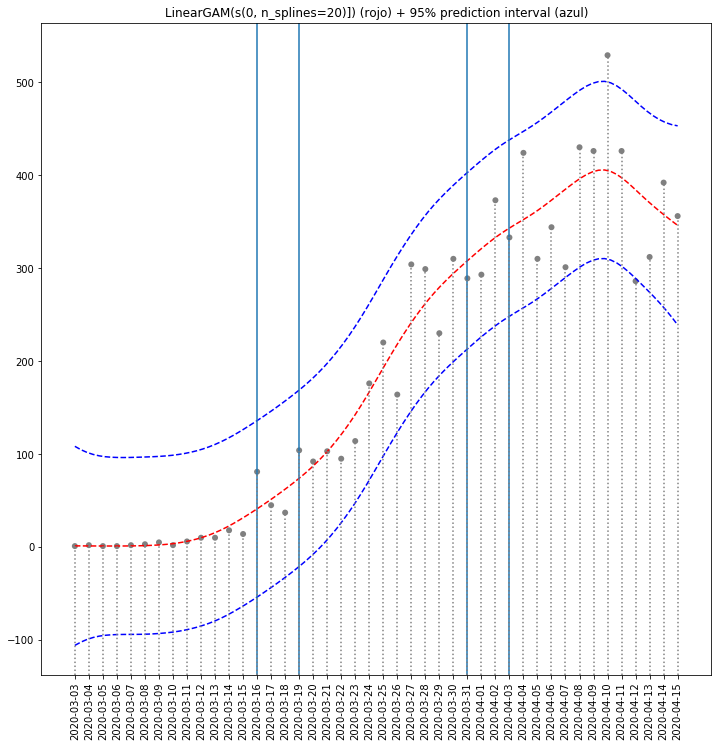

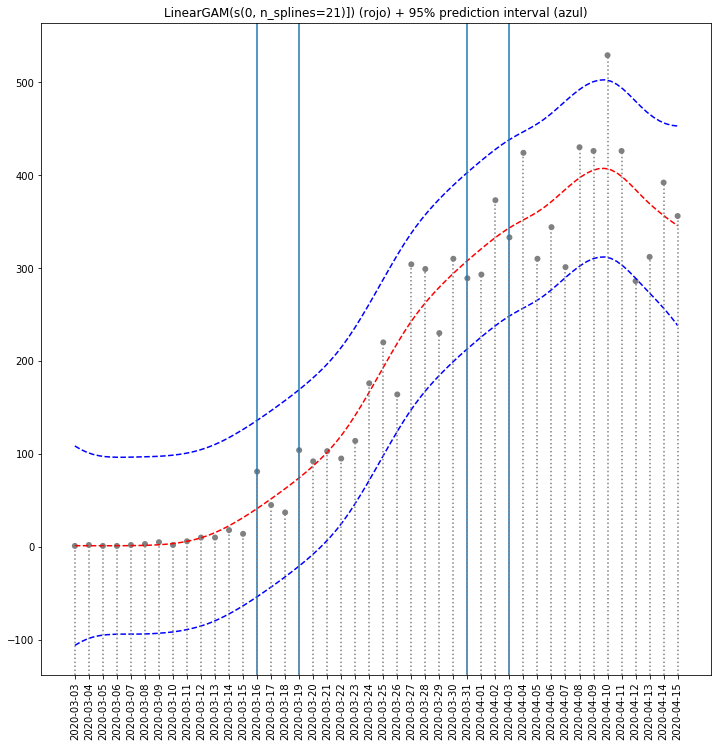

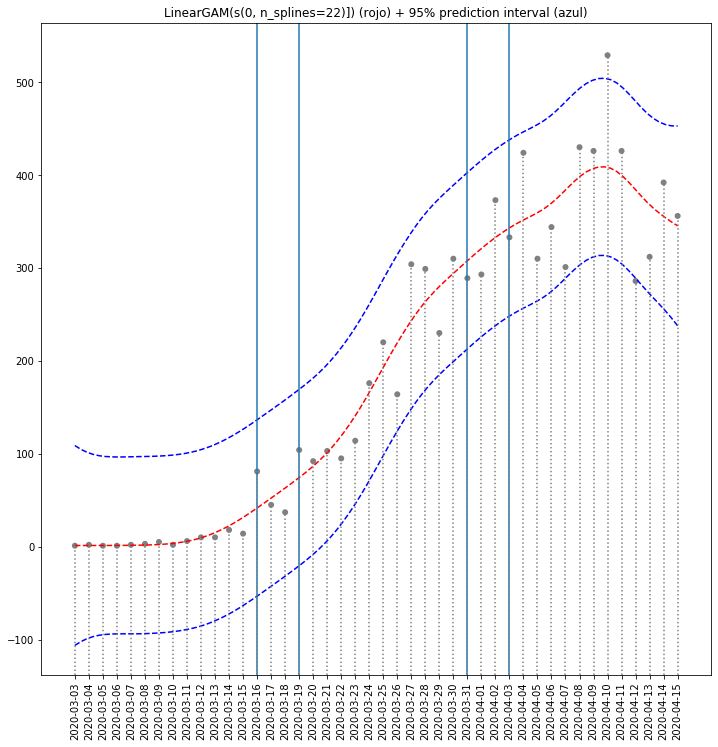

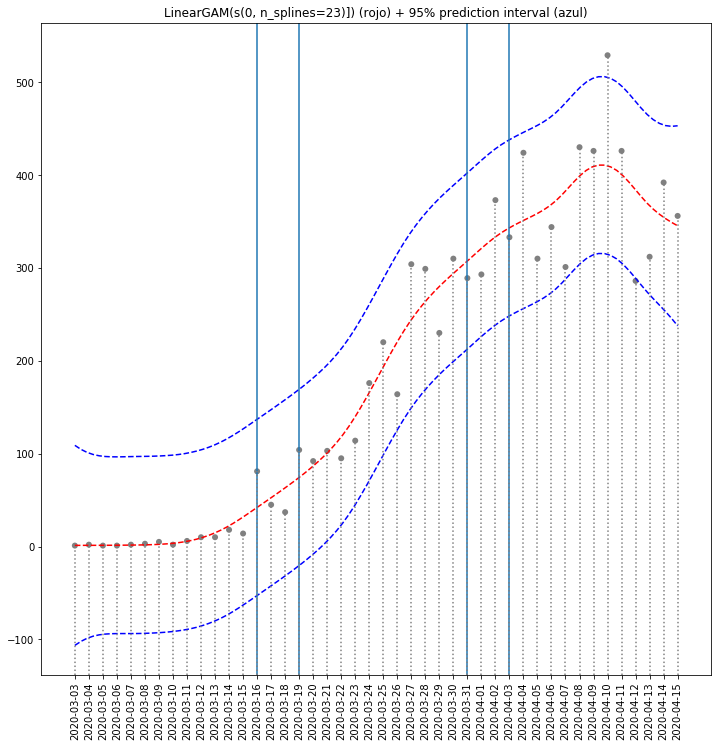

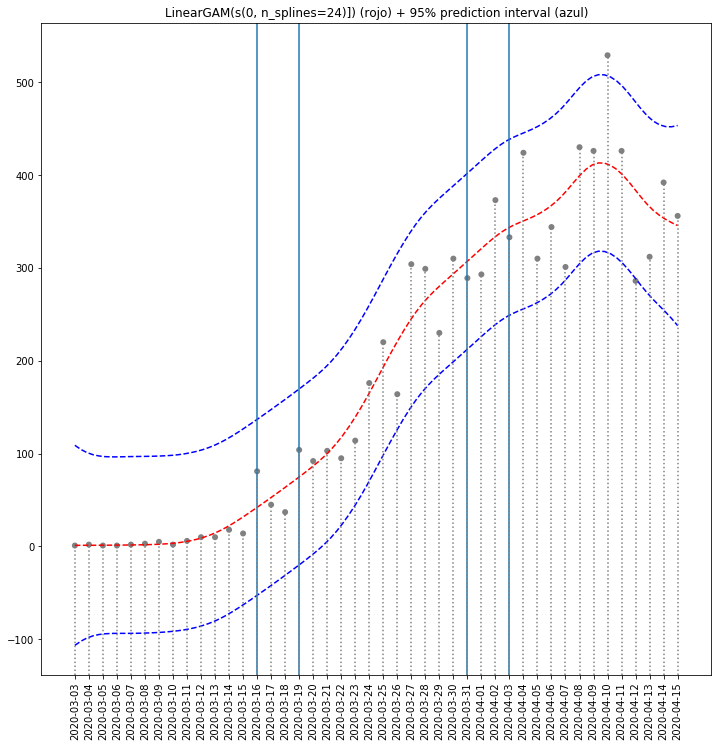

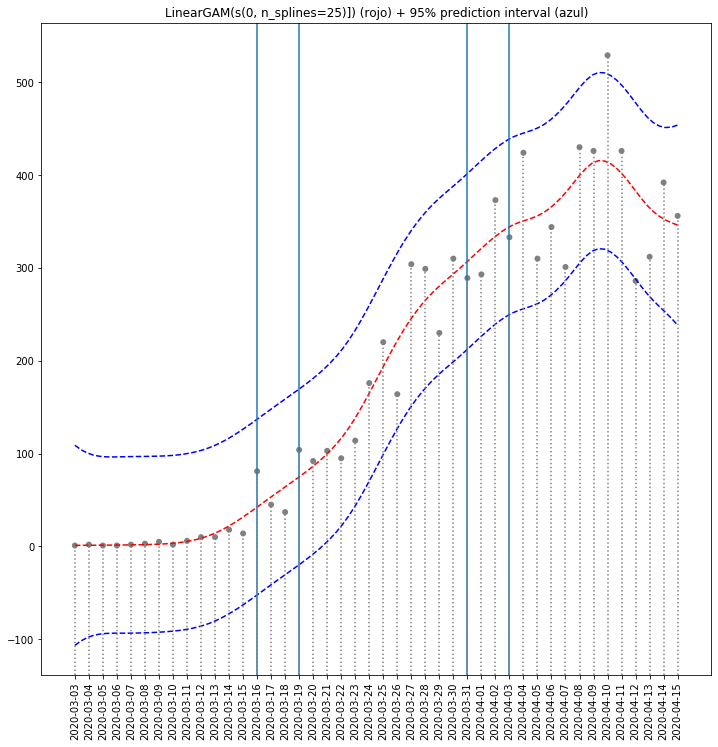

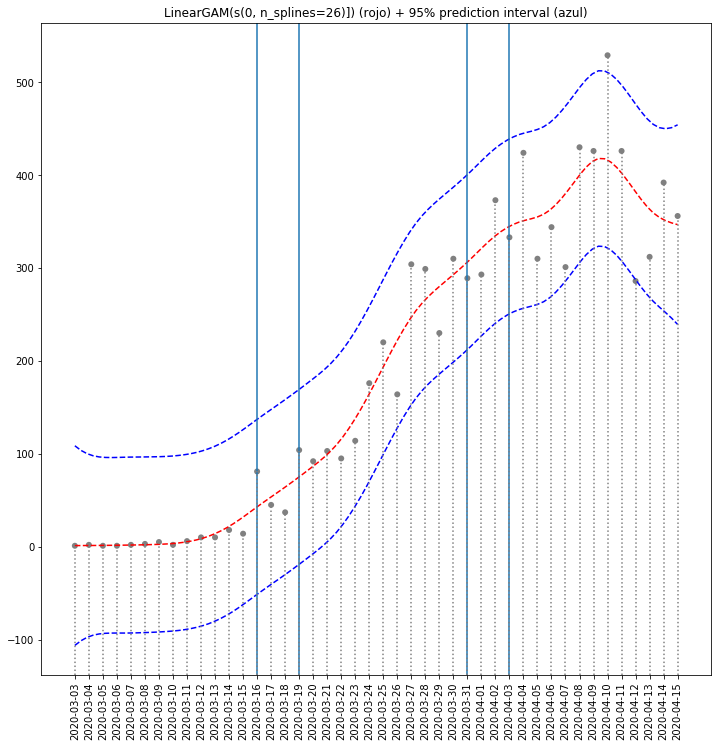

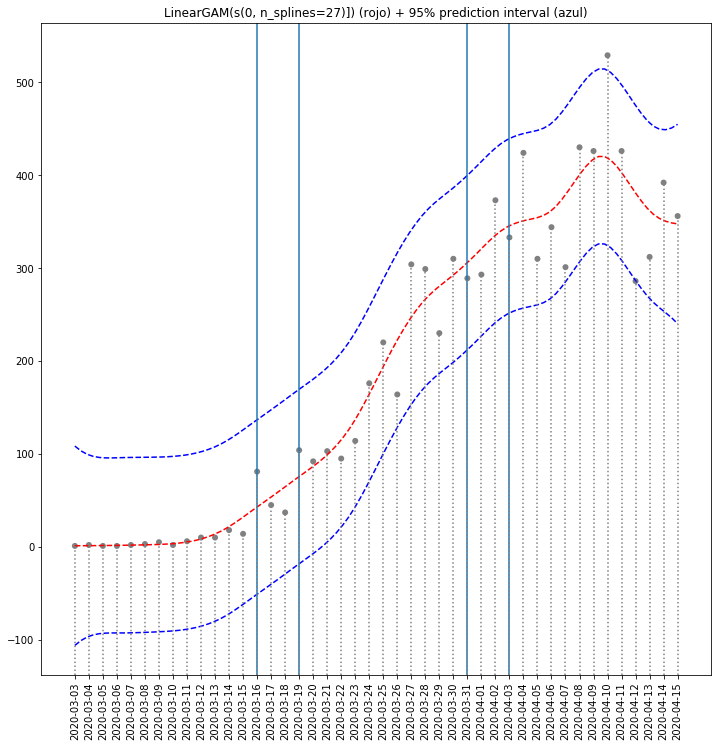

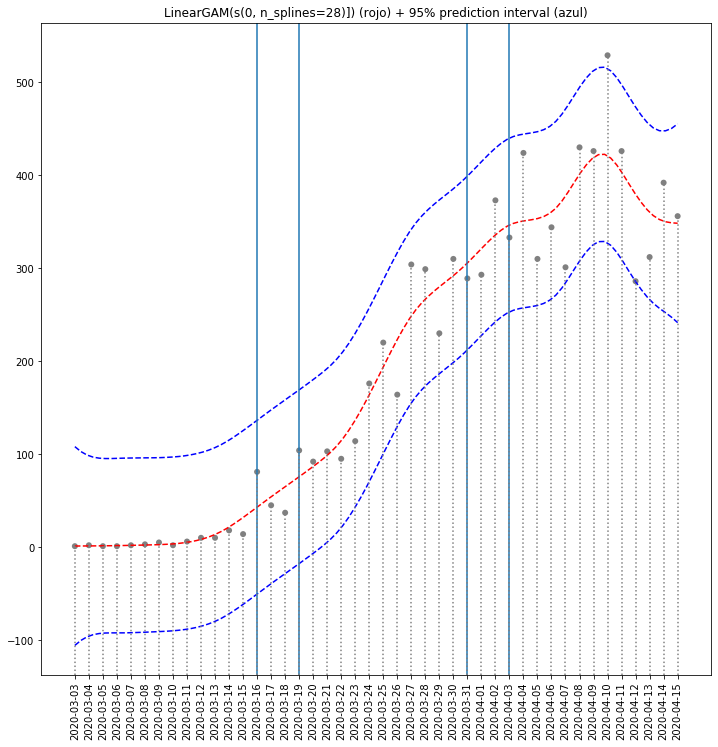

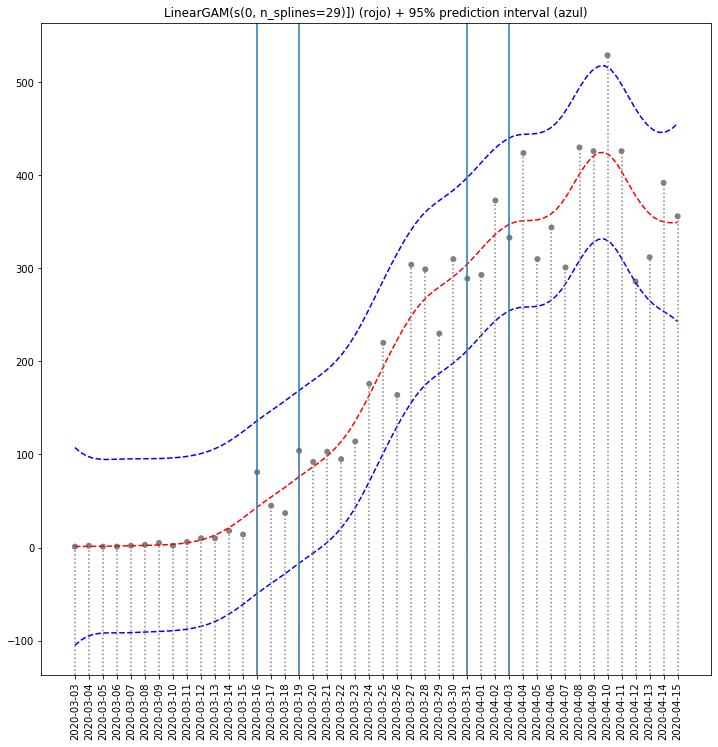

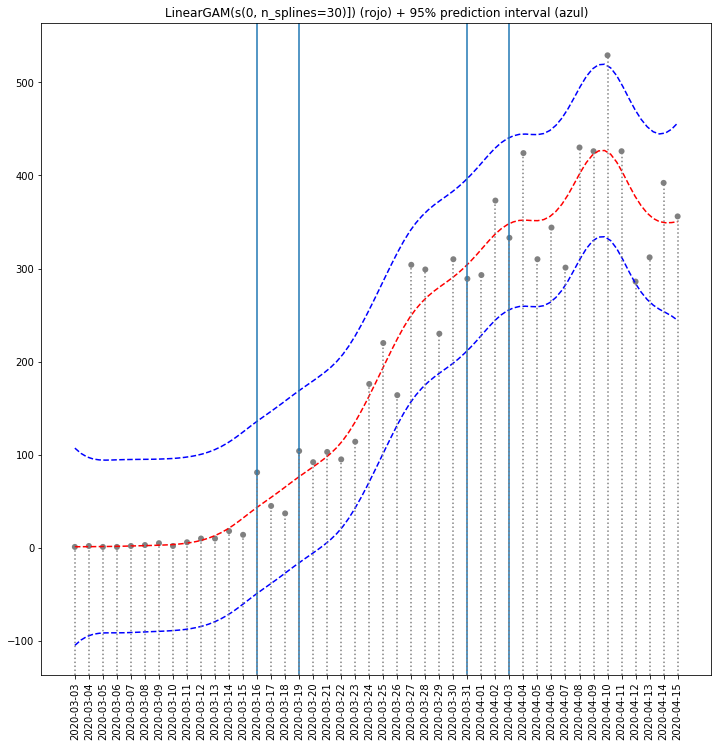

In [66]:
# Miremos un rango
# Veremos modelos muy generales donde no se pueden ver sub-tendencias clararas por un lado
# y modelos overfited por el otro donde cada variación se sobre interpreta mucho.
# La idea es entender como se comporta el modelo en un rango de hiper-parametros

for n_splines in range(10, 31):
    gam = LinearGAM(s(0, n_splines=n_splines))
    gam.fit(X, y)
    plot_gam(gam, f'LinearGAM(s(0, n_splines={n_splines})]) (rojo) + 95% prediction interval (azul)', df.ds, y, True)

In [67]:
# Miremos los coeficientes
gam.coef_

array([-180.14665846, -179.9794732 , -179.84874108, -179.53901744,
       -178.84665707, -178.27120034, -176.73251083, -171.79225008,
       -159.82530783, -139.88784074, -123.8144071 , -104.99696279,
        -89.21840351,  -69.57522916,  -28.09107605,   22.66467093,
         70.13730767,   94.51935799,  109.1380357 ,  132.6598414 ,
        162.81069587,  173.88215648,  166.25480969,  189.34796825,
        243.02909238,  252.63032601,  196.00817097,  165.5953033 ,
        168.81820823,  174.22447724,  181.15469339])